# <h1>Принятие решений в бизнесе</h1>



<b>Цели проекта</b>
<ul>
    <li>Провести приоритизацию гипотез с использованием фреймворков ICE и RICE</li>
    <li>Изучить изменение приоритизации гипотез</li>
    <li>Провести анализ A/B-теста</li>
    <li>Принять и обосновать решение по результатам теста</li>
</ul>

<b>Описание данных</b>

<h3> Данные для первой части Файл /datasets/hypothesis.csv</h3>
<ul>
    <li><strong>Hypothesis</strong> — краткое описание гипотезы;</li>
    <li><strong>Reach</strong> — охват пользователей по 10-балльной шкале;</li>
    <li><strong>Impact</strong> — влияние на пользователей по 10-балльной шкале;</li>
    <li><strong>Confidence</strong> — уверенность в гипотезе по 10-балльной шкале;</li>
    <li><strong>Efforts</strong> — затраты ресурсов на проверку гипотезы по 10-балльной шкале.</li>
</ul>

<h3>Данные для второй части</h3>

<b>Файл /datasets/orders.csv<b/>
<ul>
    <li><strong>transactionId</strong> — идентификатор заказа;</li>
    <li><strong>visitorId</strong> — идентификатор пользователя, совершившего заказ;</li>
    <li><strong>date</strong> — дата, когда был совершен заказ;</li>
    <li><strong>revenue</strong> — выручка заказа;</li>
    <li><strong>group</strong> — группа A/B-теста, в которую попал заказ.</li>
</ul>

<b>Файл /datasets/visitors.csv</b>
<ul>
    <li><strong>date</strong> — дата;</li>
    <li><strong>group</strong> — группа A/B-теста;</li>
    <li><strong>visitors</strong> — количество пользователей в указанную дату в указанной группе A/B-теста.</li>
</ul>

In [1]:
import pandas as pd 
import numpy as np
from scipy import stats as st
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )


except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision',2)

# Предобработка данных

In [3]:
def data_check(dataframe):
    print("\nОбщая информация о датафрейме:\n")
    dataframe.info()
    print("\nПропуски в каждом столбце:\n", dataframe.isnull().sum())
    print("\nКоличество дубликатов:", dataframe.duplicated().sum())  

In [4]:
data_check(hypothesis)


Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Пропуски в каждом столбце:
 Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Количество дубликатов: 0


In [5]:
data_check(orders)


Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Пропуски в каждом столбце:
 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Количество дубликатов: 0


In [6]:
data_check(visitors)


Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Пропуски в каждом столбце:
 date        0
group       0
visitors    0
dtype: int64

Количество дубликатов: 0


Предварительно изучив данные, видим, что они не имеют пропусков и дубликатов, столбцы с датой приведены к нужному типу, а значит можем рассмотреть их подробнее. 

In [7]:
def data_head(df):
    print(df.head(5))

In [8]:
dfs = [hypothesis, orders, visitors]
for df in dfs:
    data_head(df)
    

                                          Hypothesis  Reach  Impact  \
0  Добавить два новых канала привлечения трафика,...      3      10   
1  Запустить собственную службу доставки, что сок...      2       5   
2  Добавить блоки рекомендаций товаров на сайт ин...      8       3   
3  Изменить структура категорий, что увеличит кон...      8       3   
4  Изменить цвет фона главной страницы, чтобы уве...      3       1   

   Confidence  Efforts  
0           8        6  
1           4       10  
2           7        3  
3           3        8  
4           1        1  
   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     1650     B
1     2804400009  3642806036  2019-08-15      730     B
2     2961555356  4069496402  2019-08-15      400     A
3     3797467345  1196621759  2019-08-15     9759     B
4     2282983706  2322279887  2019-08-15     2308     B
         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       6

# Часть 1. Приоритизация гипотез.


В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

<b>Задача</b> 

- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [9]:
pd.options.display.max_colwidth=100

In [10]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values(by='ICE', ascending=False, inplace=True)
hypothesis.reset_index(drop=True)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
0,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [11]:
hypothesis.iloc[0,0]

'Запустить акцию, дающую скидку на товар в день рождения'

В приоритете у нас оказалась гипотеза о запуске скидки на товар в честь Дня рождения. Ее приоритет составил 16.20 в сравнении с остальными гипотезами.

In [12]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values(by='RICE', ascending=False, inplace=True)
hypothesis.reset_index(drop=True)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.0
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.0
4,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
5,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


hypothesis.iloc[0,0]

После применения фреймворка RICE приоритет гипотез изменился, так как данный фреймворк подразумевает использование параметра Reach, отображающего на какое количество пользователей повлияет гипотеза. Использование данного параметра поможет охватить большее количество пользователей, так как введение формы подписки на все основные страницы будет отображено для каждого пользователя. При использовании параметра ICE мы можем охватить только тех пользователей, которые отмечают свой День рождения в даты, в которые будет тестироваться гипотеза. 

# Часть 2. Анализ A/B-теста

<b>Задача 1<b/>
    
Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [13]:
# visitors_orders = visitors.merge(orders, how='left')
# visitors_orders.head(10)

In [14]:
# visitorsA = visitors_orders.query('group == "A"')
# visitorsB = visitors_orders.query('group == "B"')

In [15]:
visitorsA = orders.query('group =="A"')['visitorId']
visitorsB = orders.query('group =="B"')['visitorId']

In [16]:
print('Количество заказов пользователей группы А:', orders.query('group =="A"').shape[0])
print('Количество заказов пользователей группы B:', orders.query('group =="B"').shape[0])

Количество заказов пользователей группы А: 557
Количество заказов пользователей группы B: 640


Группа  В вышла больше, чем группа А, поэтому теперь нужно проверить, не пересекаются ли они, так как это может дать некорректный результат А/В-теста.

In [17]:
visitorsAB = orders.loc[orders['visitorId'].isin(visitorsA)& orders['visitorId'].isin(visitorsB),'visitorId'].unique()

In [20]:
orders = orders.loc[~orders['visitorId'].isin(visitorsAB)]

In [21]:
print ('Количество заказов пользователей группы А: ', orders.query('group == "A"').shape[0])
print ('Количество заказов пользователей группы В: ',orders.query('group == "B"').shape[0])

Количество заказов пользователей группы А:  468
Количество заказов пользователей группы В:  548


In [23]:
visitors_orders_new = orders.merge(visitors, how='left')

In [24]:
visitorsA = visitors_orders_new.query('group == "A"')
visitorsB = visitors_orders_new.query('group == "B"')

После удаления совпадающих пользователей выборки уменьшились, но группа B все равно осталась больше группы А. Так как на данном этапе с этим ничего не возможно сделать, юудет учитывать это в дальнейшем решении.

In [26]:
grouped_visitorsA = visitorsA.groupby(['date', 'group']).agg({'visitors': 'sum','revenue': 'sum', 'transactionId': 'count'}).reset_index()
grouped_visitorsA.head(5)

,date,group,visitors,revenue,transactionId
0,2019-08-01,A,16537,142779,23
1,2019-08-02,A,11761,91602,19
2,2019-08-03,A,12168,112473,24
3,2019-08-04,A,7887,41176,11
4,2019-08-05,A,16632,86383,22


In [27]:
grouped_visitorsA = grouped_visitorsA.copy()
grouped_visitorsA['cumulative_revenue'] = grouped_visitorsA['revenue'].cumsum()
grouped_visitorsA.head(5)

,date,group,visitors,revenue,transactionId,cumulative_revenue
0,2019-08-01,A,16537,142779,23,142779
1,2019-08-02,A,11761,91602,19,234381
2,2019-08-03,A,12168,112473,24,346854
3,2019-08-04,A,7887,41176,11,388030
4,2019-08-05,A,16632,86383,22,474413


In [28]:
grouped_visitorsB = visitorsB.groupby(['date', 'group']).agg({'visitors': 'sum','revenue': 'sum', 'transactionId': 'count'}).reset_index()
grouped_visitorsB.head(5)

,date,group,visitors,revenue,transactionId
0,2019-08-01,B,12121,59758,17
1,2019-08-02,B,13363,162043,23
2,2019-08-03,B,7126,67049,14
3,2019-08-04,B,10780,96890,14
4,2019-08-05,B,14847,89908,21


In [29]:
grouped_visitorsB = grouped_visitorsB.copy()
grouped_visitorsB['cumulative_revenue'] = grouped_visitorsB['revenue'].cumsum()
grouped_visitorsB.head(5)

,date,group,visitors,revenue,transactionId,cumulative_revenue
0,2019-08-01,B,12121,59758,17,59758
1,2019-08-02,B,13363,162043,23,221801
2,2019-08-03,B,7126,67049,14,288850
3,2019-08-04,B,10780,96890,14,385740
4,2019-08-05,B,14847,89908,21,475648


In [30]:
grouped_visitorsA['orders'] = grouped_visitorsA['transactionId'].cumsum()
grouped_visitorsB['orders'] = grouped_visitorsB['transactionId'].cumsum()
# grouped_visitorsA = grouped_visitorsA.drop(columns=['transactionId'], axis=1)
# grouped_visitorsB = grouped_visitorsB.drop(columns=['transactionId'], axis=1)

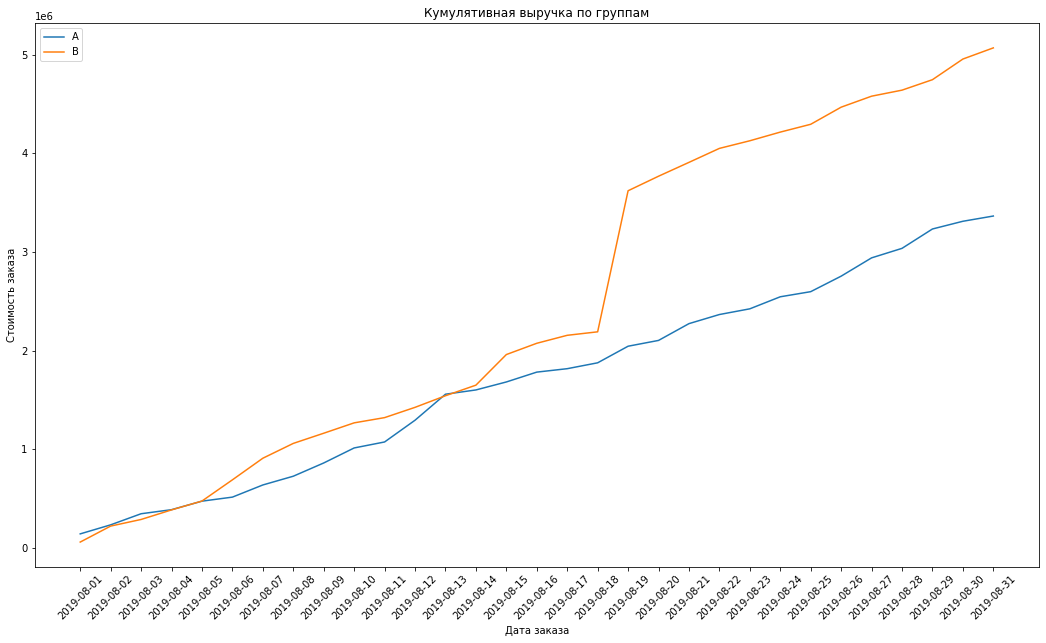

In [31]:
plt.figure(figsize=(18, 10))
plt.plot(grouped_visitorsA['date'], grouped_visitorsA['cumulative_revenue'], label='A')
plt.plot(grouped_visitorsB['date'], grouped_visitorsB['cumulative_revenue'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата заказа')
plt.ylabel('Стоимость заказа')
plt.legend();

Выручка в группе А растет постепенно, в отличие от группы В, в которой наблюдается резкий скачок после 17.08. Это может быть обусловлено как увеличением количества заказов, так и увеличением их стоимости. 

<b>Задача 2</b>

<b>Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения</b>

In [32]:
grouped_visitorsA['mean_check'] = grouped_visitorsA['cumulative_revenue'] / grouped_visitorsA['orders']
grouped_visitorsB['mean_check'] = grouped_visitorsB['cumulative_revenue'] / grouped_visitorsB['orders']

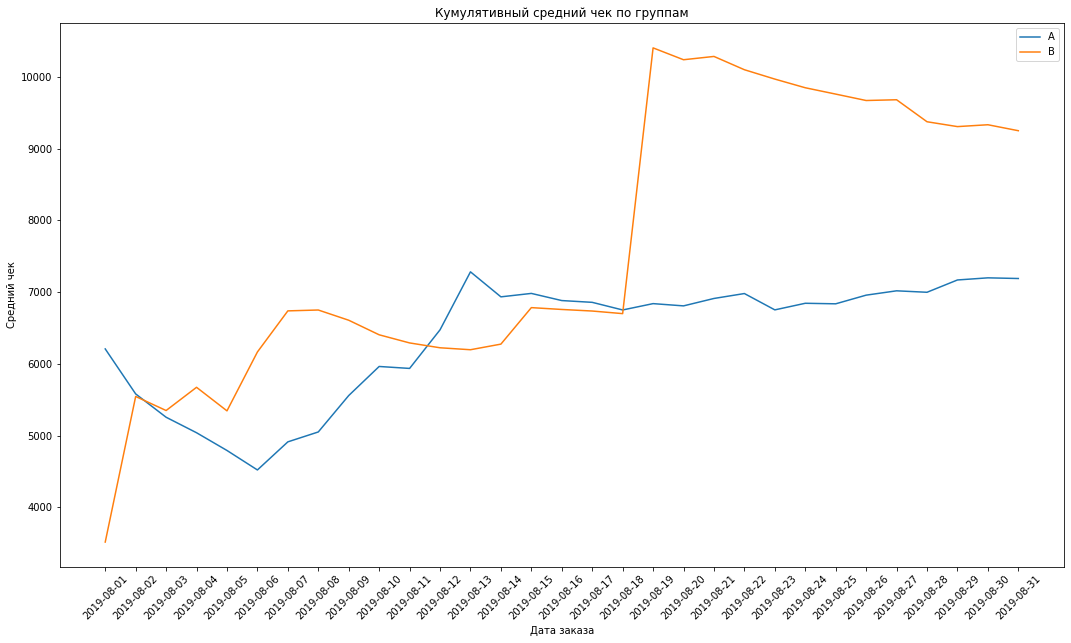

In [33]:
plt.figure(figsize=(18, 10))
plt.plot(grouped_visitorsA['date'],grouped_visitorsA['mean_check'], label='A')
plt.plot(grouped_visitorsB['date'], grouped_visitorsB['mean_check'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата заказа')
plt.ylabel('Средний чек')
plt.legend();

Группа В приносит больше дохода, чем группа А, к 17 числу они выравниваются, но 19 числа снова резкий скачок в группе В, после которой средний чек снова начинает снижаться. Вероятно, все же, дело в крупной покупке.

<b>Задача 3</b>

<b>Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения</b>

In [34]:
grouped_visitorsB['diff'] = grouped_visitorsB['mean_check'] / grouped_visitorsA['mean_check'] - 1

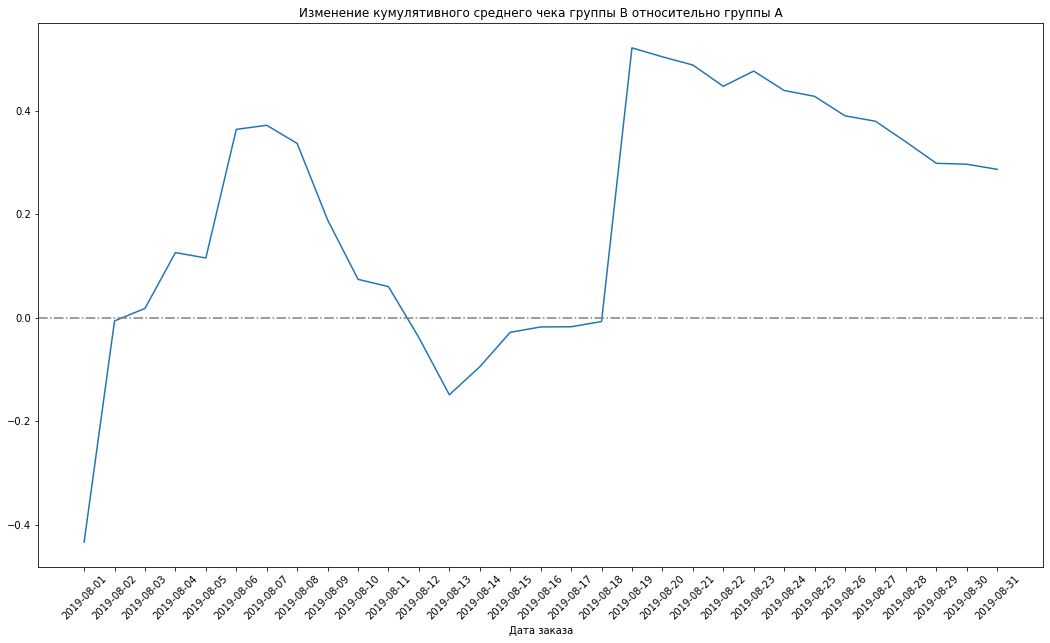

In [35]:
plt.figure(figsize=(18, 10))
plt.plot(grouped_visitorsB['date'],grouped_visitorsB['diff'])
plt.xticks(rotation=45)
plt.title('Изменение кумулятивного среднего чека группы В относительно группы А')
plt.xlabel('Дата заказа')
plt.axhline(y=0, color='grey', linestyle='-.');

После данного графика можем увидеть что в данных имеется два скачка в среднем чеке группы В: один после 3 числа, второй 18-19 числа. Возможно, крупные покупки совершались еще и в начале месяца, либо же мы имеем дело с выбросами.

<b>Задача 4</b>

<b>Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения</b>

In [40]:
dates_groups = orders[['date','group']].drop_duplicates()

In [41]:
orders_new = (dates_groups
                     .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date']
                                                            , orders['group'] ==  x['group'])]
                    .agg({'date':'max', 'group':'max', 'revenue':'sum', 'transactionId':'nunique'}), axis=1) 
                    .sort_values(by=['date','group']))


orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [42]:
visitors_new = (dates_groups
                     .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date']
                                                            , visitors['group'] ==  x['group'])]
                    .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1) 
                    .sort_values(by=['date','group']))
visitors_new.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [43]:
cumulative_orders_visitors = orders_new.merge(visitors_new, on=['date','group']) 
cumulative_orders_visitors.head(5)

,date,group,revenue,transactionId,visitors
0,2019-08-01,A,142779,23,719
1,2019-08-01,B,59758,17,713
2,2019-08-02,A,234381,42,1338
3,2019-08-02,B,221801,40,1294
4,2019-08-03,A,346854,66,1845


In [44]:
orders_a = cumulative_orders_visitors.loc[cumulative_orders_visitors['group'] == 'A']
orders_b = cumulative_orders_visitors.loc[cumulative_orders_visitors['group'] == 'B']

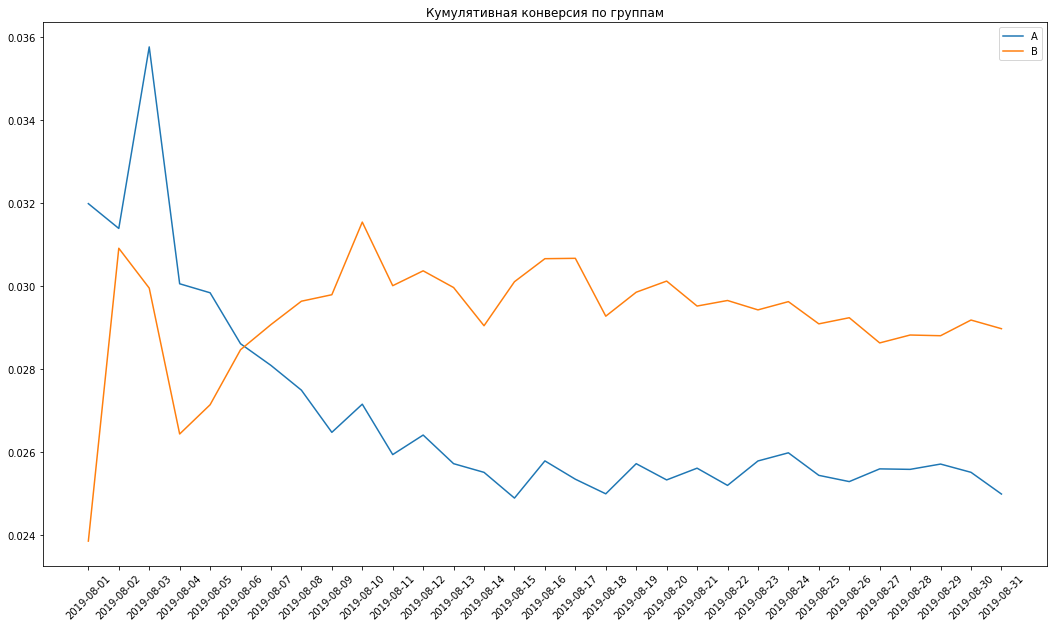

In [45]:
plt.figure(figsize=(18, 10))
plt.plot(orders_a['date'], orders_a['transactionId'] / orders_a['visitors'], label='A')
plt.plot(orders_b['date'], orders_b['transactionId'] / orders_b['visitors'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная конверсия по группам')
plt.legend();

В начале месяца группы пересекаются, но дальше до конца теста группа В лидирует, хоть и идут они параллельно друг другу. 

<b>Задача 5</b>

<b>Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения</b>

In [47]:
merged_orders = orders_a.merge(orders_b, on=['date'],suffixes=('_a', '_b'))
merged_orders.head(5)

,date,group_a,revenue_a,transactionId_a,visitors_a,group_b,revenue_b,transactionId_b,visitors_b
0,2019-08-01,A,142779,23,719,B,59758,17,713
1,2019-08-02,A,234381,42,1338,B,221801,40,1294
2,2019-08-03,A,346854,66,1845,B,288850,54,1803
3,2019-08-04,A,388030,77,2562,B,385740,68,2573
4,2019-08-05,A,474413,99,3318,B,475648,89,3280


In [48]:
merged_orders['mean_orders_a'] = merged_orders['transactionId_a'] / merged_orders['visitors_a']
merged_orders['mean_orders_b'] = merged_orders['transactionId_b'] / merged_orders['visitors_b']

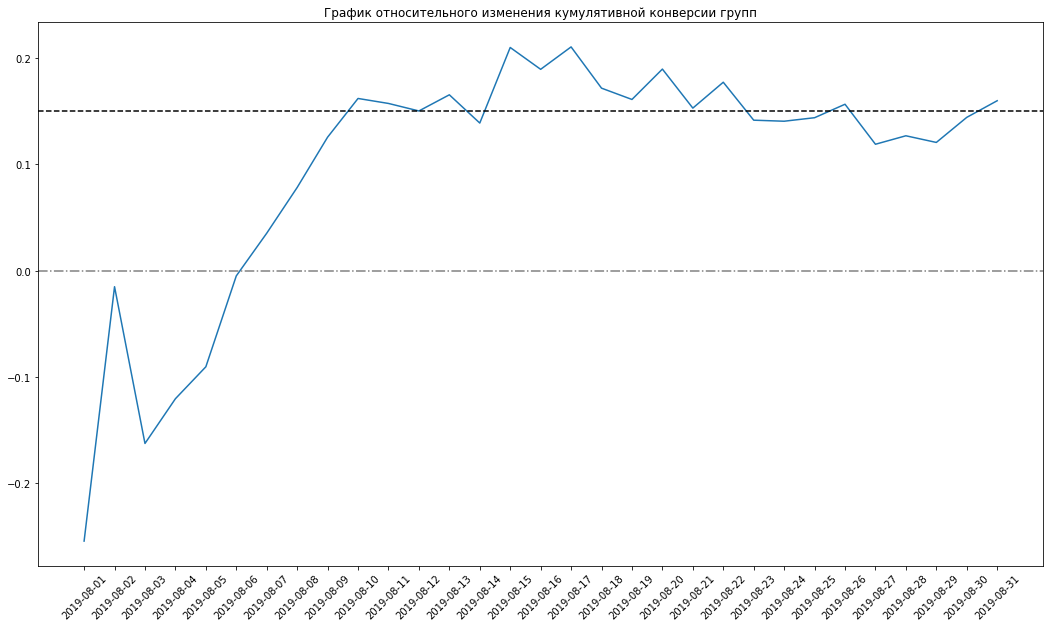

In [49]:
plt.figure(figsize=(18, 10))
plt.plot(merged_orders['date'], merged_orders['mean_orders_b'] / merged_orders['mean_orders_a'] -1)
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивной конверсии групп')

plt.axhline(y=0, color='grey', linestyle='-.')
plt.axhline(y=0.15, color='black', linestyle='--');

На графике видно, что группа В опережает группу А. Возможно, в группу попали шопоголики. 

<b>Задача 6</b>

<b>Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения</b>

In [50]:
user_orders = orders.groupby('visitorId')['revenue'].count().reset_index()
user_orders.columns = ['visitors', 'orders']
user_orders.head(5)

,visitors,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


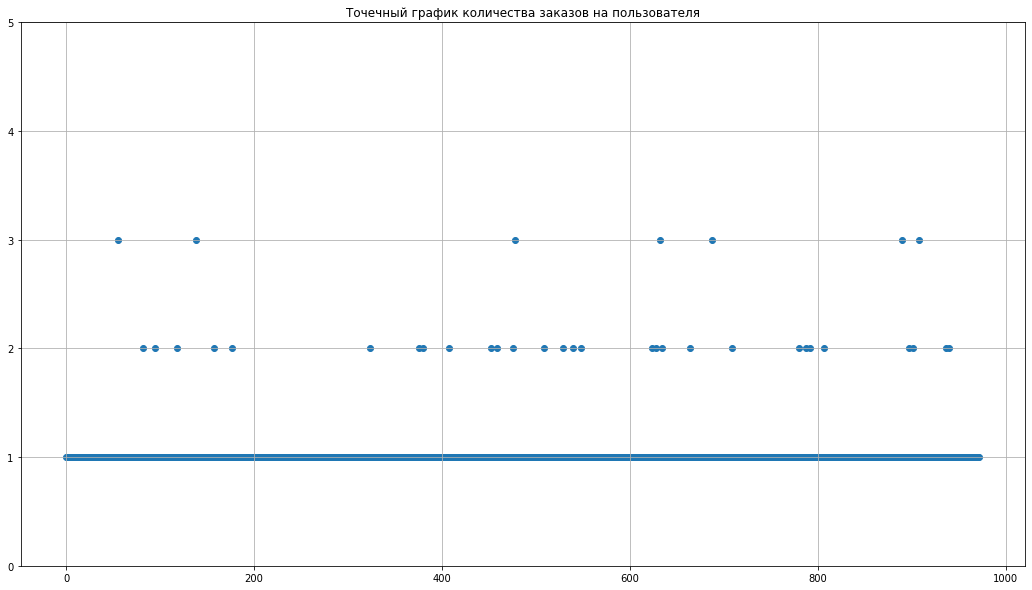

In [51]:
plt.figure(figsize=(18, 10))
x_values = pd.Series(range(0,user_orders['orders'].count()))
plt.scatter(data=user_orders, x=x_values, y='orders') 
plt.grid()
plt.title('Точечный график количества заказов на пользователя')
plt.yticks([0,1,2,3,4, 5]);

В основном пользователи делают 1 заказ, реже 2 или 3. Но также у нас имеются "постояные" клиенты, которые сделали и 3 заказа.

<b>Задача 7</b>

<b>Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей</b>

In [52]:
print(np.percentile(user_orders['orders'], [95, 99])) 

[1. 2.]


Отсечем данные, выбивающиеся за границы 99 перцентиля и построим график еще раз.

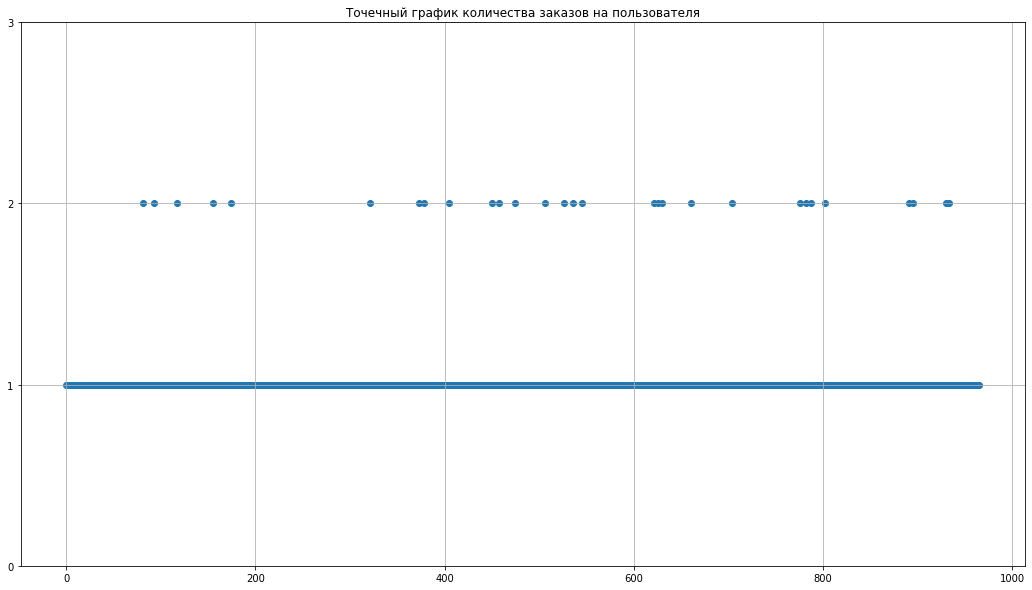

In [53]:
percentile_99 = np.percentile(user_orders['orders'], [99])[0]
orders_per_99 = user_orders.query('orders <= @percentile_99')

plt.figure(figsize=(18, 10))
x_values = pd.Series(range(0,orders_per_99['orders'].count()))
plt.scatter(data=orders_per_99, x=x_values, y='orders') 
plt.grid()
plt.title('Точечный график количества заказов на пользователя')
plt.yticks([0,1,2, 3]);

Теперь график выглядит  более аккуратным и читабельным.

<b>Задача 8</b>

<b>Постройте точечный график стоимостей заказов. Сделайте выводы и предположения</b>

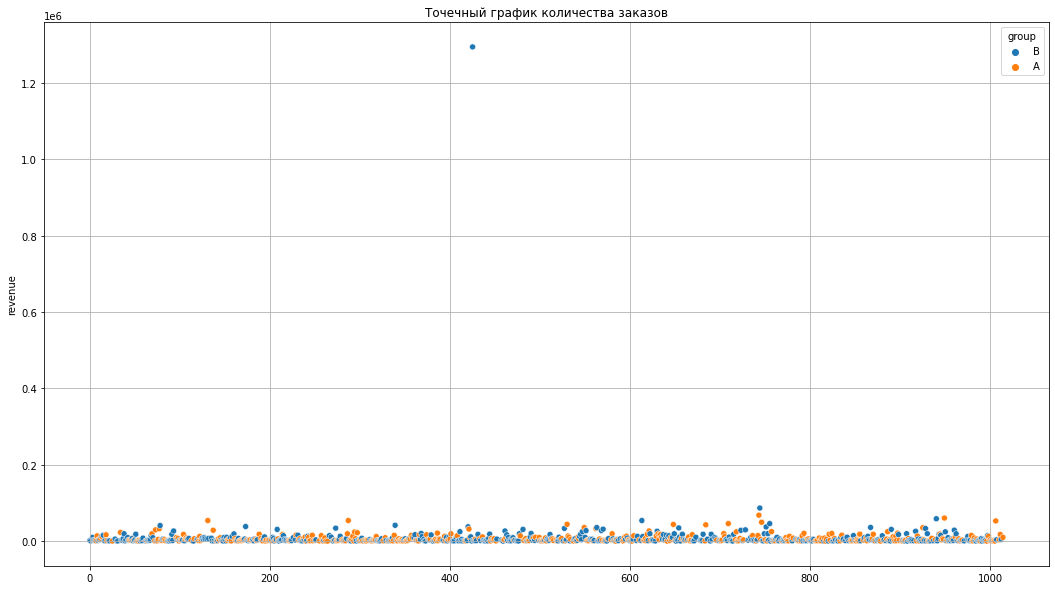

In [54]:
x_values = pd.Series(range(0,orders['revenue'].count()))
plt.figure(figsize=(18, 10))
sns.scatterplot(x=x_values, y="revenue", hue="group", data=orders)
plt.grid()
plt.title('Точечный график количества заказов');

На графике видно, что у нас имеется 2 выброса в группе В. Вероятно, они и искажалирезультаты в ходе предыдущего исследования и давали скачки на графиках. Сейчас мы можем удалить выбросы и детальнее изучить полученные данные.

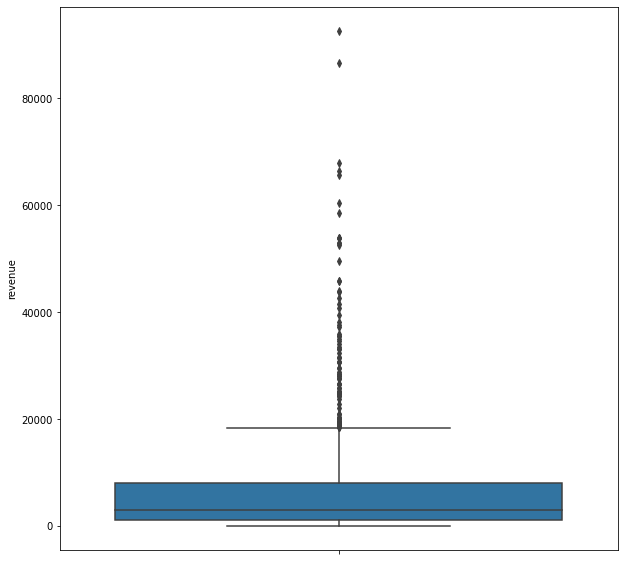

In [55]:
clean_orders = orders.query('revenue<200000')
plt.figure(figsize=(10, 10))
sns.boxplot(y=clean_orders['revenue']);

Все, что выходит за границы 20000 является выбросами, поэтому такую выручку мы учитывать не будем и построим новый график распределения выручки по группам. 

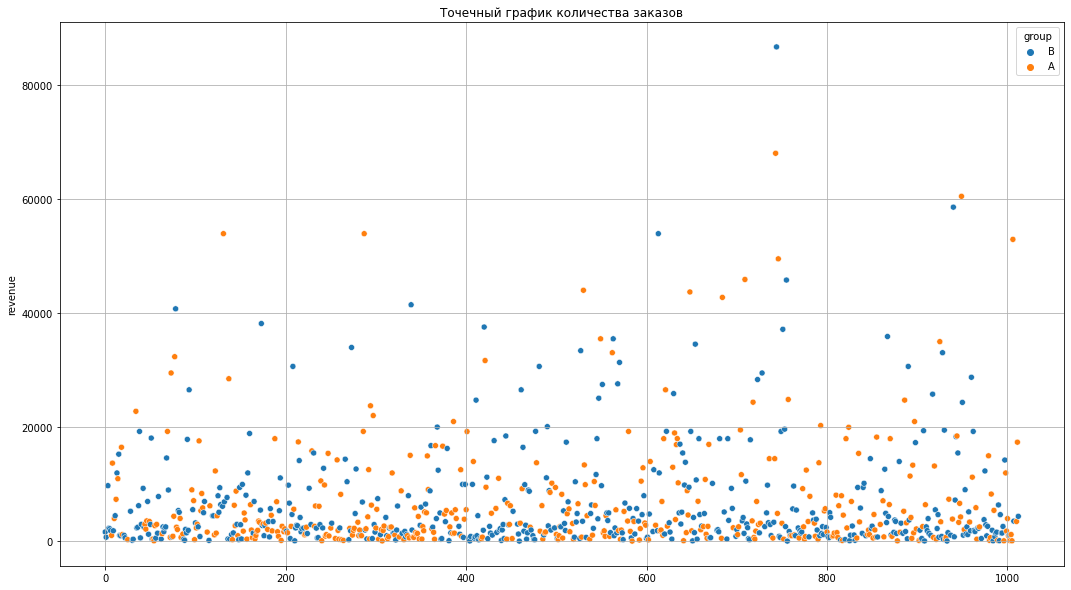

In [56]:
x_values = pd.Series(range(0,clean_orders['revenue'].count()))

plt.figure(figsize=(18, 10))
sns.scatterplot(x=x_values, y="revenue", hue="group", data=clean_orders)
plt.grid()
plt.title('Точечный график количества заказов');

На этом графике данные видны более четко. У нас все еще имеется некоторое количество дорогих заказов, но пока не будем их удалять.

<b>Задача 9</b>

<b>Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей</b>

In [57]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Все, что выше 99 перцентиля можно убрать и еще раз посмотреть на данные.

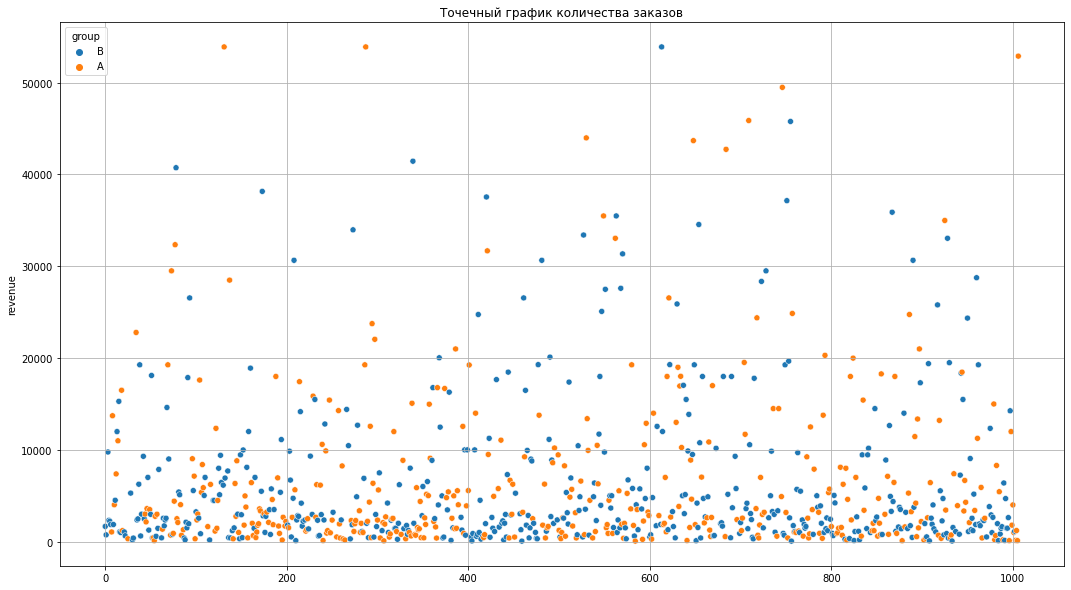

In [58]:
percentile_99 = np.percentile(orders['revenue'], [99])[0]
orders_per_99 = orders.query('revenue <= @percentile_99')

x_values = pd.Series(range(0,orders_per_99['revenue'].count()))

plt.figure(figsize=(18, 10))
sns.scatterplot(x=x_values, y="revenue", hue="group", data=orders_per_99)
plt.grid()
plt.title('Точечный график количества заказов');

<b>Задача 10</b>

<b>Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения</b>

- Н0 - среднее количество заказов пользователей группы А и группы В на сырых данных одинаковое
- Н1 - среднее количество заказов пользователей по группам А и В на "сырых" данных различается 
- уровень значимости  α — 0.05

In [59]:
order_counts = orders.groupby(['visitorId', 'group'])['transactionId'].count().reset_index()
order_counts.head(5)

,visitorId,group,transactionId
0,5114589,B,1
1,6958315,B,1
2,11685486,A,1
3,39475350,B,1
4,47206413,B,1


In [60]:
ordersA = order_counts.query('group == "A"').groupby('visitorId')['transactionId'].nunique().reset_index()
ordersA.columns = ['visitorId', 'orders']

ordersB = order_counts.query('group == "B"').groupby('visitorId')['transactionId'].nunique().reset_index()
ordersB.columns = ['visitorId', 'orders']

Найдем количество пользователей по группам, не сделавших ни одного заказа.

In [61]:
no_ordersA = visitors.query('group == "A"')['visitors'].sum() - len(ordersA['orders'])
no_ordersB =  visitors.query('group == "B"')['visitors'].sum() - len(ordersB['orders'])

In [62]:
no_ordersA = pd.Series(0, index=np.arange(no_ordersA), name='orders')
no_ordersB = pd.Series(0, index=np.arange(no_ordersB), name='orders')

In [63]:
SampleA = pd.concat([ordersA['orders'], no_ordersA])
SampleB = pd.concat([ordersB['orders'], no_ordersB])

In [64]:
print('p_value:', round(st.mannwhitneyu(SampleA, SampleB)[1], 3))
print('Статистическая значимость:', round(orders.query('group == "B"')['transactionId'].mean()
                                          / orders.query('group == "A"')['transactionId'].mean() - 1, 3))
print('Средняя конверсия группы А:', round(SampleA.mean() * 100, 1))
print('Средняя конверсия группы B:', round(SampleB.mean()* 100, 1))

p_value: 0.011
Статистическая значимость: 0.021
Средняя конверсия группы А: 2.4
Средняя конверсия группы B: 2.8


Так как p-value 0.011, что значительно меньше уровня значимости α, то мы отклоняем нулевую гипотезу о равенстве среднего количества заказов по группам на сырых данных. После рассчета среднего значения можно убедиться, что оно действительно различается на 0.4 и статистически значима на 21%. 

<b>Задача 11</b>

<b>Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения</b>

- Н0 — средний чек группы А на "сырых" данных равен среднему чеку группы В
- Н1 — средний чек группы А на "сырых" данных не равен среднему чеку группы В
- уровень значимости  α — 0.05

In [65]:
meancheckA = orders.query('group == "A"')['revenue']
meancheckB = orders.query('group == "B"')['revenue']

In [66]:
print('p_value:', round(st.mannwhitneyu(meancheckA, meancheckB)[1], 3))
print('Статистическая значимость:', round(meancheckB.mean() / meancheckA.mean() - 1, 3))
print('Средняя конверсия группы А:', round(meancheckA.mean() * 100, 1))
print('Средняя конверсия группы B:', round(meancheckB.mean()* 100, 1))

p_value: 0.829
Статистическая значимость: 0.287
Средняя конверсия группы А: 718943.6
Средняя конверсия группы B: 924994.9


p-value составляет 0.829, что больше уровня значимости α, поэтому мы не можем отвергнуть нулевую гипотезу о равенстве среднего чека обеих групп. Несмотря на разницу среднего чека в 206 у.е. мы принимаем нулевую гипотезу. 

<b>Задача 12</b>

<b>Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения</b>

- Н0 - среднее количество заказов пользователей группы А и группы В на "очищенных" данных одинаковое
- Н1 - среднее количество заказов пользователей по группам А и В на "очищенных" данных различается 
- уровень значимости  α — 0.05

In [67]:
clean_ordersA = visitorsA.groupby('visitorId')['transactionId'].nunique().reset_index()
clean_ordersA.columns=['visitorsId','orders']

clean_ordersB = visitorsB.groupby('visitorId')['transactionId'].nunique().reset_index()
clean_ordersB.columns=['visitorsId','orders']

In [68]:
no_clean_ordersA = visitors.query('group == "A"')['visitors'].sum() - len(clean_ordersA['orders'])
no_clean_ordersB =  visitors.query('group == "B"')['visitors'].sum() - len(clean_ordersB['orders'])

Найдем количество пользователей, не сделавших ни одного заказа. 

In [69]:
no_clean_ordersA = pd.Series(0, index=np.arange(no_clean_ordersA), name='orders')
no_clean_ordersB = pd.Series(0, index=np.arange(no_clean_ordersB), name='orders')

In [70]:
Sample_clean_A = pd.concat([clean_ordersA['orders'], no_clean_ordersA])
Sample_clean_B = pd.concat([clean_ordersB['orders'], no_clean_ordersB])

In [71]:
print('p_value:', round(st.mannwhitneyu(Sample_clean_A, Sample_clean_B)[1], 3))
print('Статистическая значимость:', round(visitors_orders_new.query('group == "B"')['transactionId'].mean()
                                          / visitors_orders_new.query('group == "A"')['transactionId'].mean() - 1, 3))
print('Средняя конверсия группы А:', round(Sample_clean_A.mean() * 100, 1))
print('Средняя конверсия группы B:', round(Sample_clean_B.mean()* 100, 1))

p_value: 0.011
Статистическая значимость: 0.021
Средняя конверсия группы А: 2.5
Средняя конверсия группы B: 2.9


Так как полученное значение p-value составило меньше уровня статистической значимости, то мы отвергаем нулевую гипотезу о равенстве среднего количества заказов в группе А и группе В. Конверсия группы В действительно выше на целых 0.4 единицы. 

<b>Задача 13</b>

<b>Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения</b>

- Н0 — средний чек группы А на "очищенных" данных равен среднему чеку группы В
- Н1 — средний чек группы А на "очищенных" данных не равен среднему чеку группы В
- уровень значимости α — 0.05

In [72]:
clean_meancheckA = orders_per_99.query('group == "A"')['revenue']
clean_meancheckB = orders_per_99.query('group == "B"')['revenue']

In [73]:
print('p_value:', round(st.mannwhitneyu(clean_meancheckA, clean_meancheckB)[1], 3))
print('Статистическая значимость:', round(clean_meancheckB.mean() / clean_meancheckA.mean() - 1, 3))
print('Средний чек группы А:', round(clean_meancheckA.mean() * 100, 1))
print('Средний чек группы B:', round(clean_meancheckB.mean()* 100, 1))

p_value: 0.901
Статистическая значимость: -0.032
Средний чек группы А: 650454.9
Средний чек группы B: 629882.7


В очищенных данных аналогичная картина что и в сырых: средний чек группы В больше чем в группе А. Статистическая значимость отрицательная, а p-value составляет 0.901, поэтому мы не можем отвергнуть нулевую гипотезу о равенстве среднего чека по группам.

<b>Задача 14</b>

<b>Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.</b>

Исходя из полученных результатов можно сделать вывод, что средние чеки на сырых и очищенных данных равны, но в группе В конверсия статистически значимо выше конверсии в группе А, а значит, принесла больше прибыли компании. Также, судя по графикам, к концу исследования линии на них стали более стабильными и практически выровнялись. Исходя из полученных результатов могу признать А/В-тест успешным и завершить тестирование. 

# Выводы

В ходе проведения исследования была проведена приоритезация гипотез. При использовании фреймворка ICE приоритетной оказалсь гипотеза о запуске акции в честь дня рождения. При использовании фреймворка RICE — в приоритете была другая гипотеза: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Различие в полученных гипотезах заключается в том, что при расчете приоритета с помощью фреймворка RICE учитывается дополнительный параметр, который показывает на какое количество окажет влияние данная гипотеза. 

Также было проведено исследование результатов А/В-теста, в ходе которых мы получили результаты, показывающие статистически значимую разницу в средней конверсии групп. Конверсия группы В оказался выше, чем в группе А, следовательно пользователи из В группы принесли больше выручки. Тем не менее, мы не смогли отвергнуть гипотезу о разности средних чеков по группам, несмотря на их различия. Так как группа В выбилась вперед по конверсии, принесла больше дохода компании, можно зафиксировать ее победу в исследовании и завершить А/В-тестирование. Также хочу отметить, что дополнительным моментом для принятия решения о прекращении тестирования является выравнивание линий на графиках. 